# SharpestMinds Project

## Introduction & Domain

**Tianchi FashionAI Global Challenge 2018**

According to official statistics from different countries, the market value of the global apparel market is worth over USD 3 trillion. Although artificial intelligence (AI) technology has been evolving along with the fashion industry, there are still different challenges in different areas that need to be addressed.

The analysis of apparel with computers could be easily affected by the dimension and shape of the apparel, distance and angle of shooting, or even how the apparel is displayed or the model is posing. For this reason Tianchi launched a competition with a objective of localizing keypoints on apparel images. This task can help to improve the performance of applications such as alignment, recognition of the local attributes and auto-editing of the images of apparel.

A task like this raises a series of additional challenges. First of all, the dataset consists of 5 different clothing categories: blouse, dress, outwear, skirt and trousers. Each category has different relevant keypoints which adds to the complexity of the model.

Another relevant challenge is dealing with a large amount of images in memory. The neural networks in this notebook are built with Keras, which is a high-level neural networks API written in Python and capable of running on top of TensorFlow, CNTK, or Theano. At the moment of writing, Keras has a built-in generator which works very well on classification tasks but doesn't directly support regression models. 

The idea of this notebook is to explore some of the ways we can deal with these challenges.

## Data

All images are from the Alibaba e-Commerce platform and are more than 54.000 images in total. Most of the images are 512x512 pixels although the size varies slightly throughout the dataset.

This specific dataset concentrates on the keypoint localization of women apparel. There are in total six subsets according to the following six clothes categories: blouse, outwear, trousers, skirt, dress and jumpsuit, respectively. But the organizers decided to omit the jumpsuit since it is uncommon in the real-world scenario. 


## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## First look at the data

Before building any type of model it is useful to first take a quick look at the data at hand with a sample:

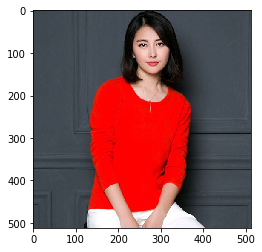

In [3]:
img = plt.imread('data/valid/blouse/'+os.listdir('data/valid/blouse')[0])
plt.imshow(img);

In [4]:
img.shape

(512, 512, 3)

As stated earlier, most images are 512x512 color images. They are taken in different settings with or without people. Some images have several types of clothing in the images, like the one above, and some only have a specific piece of clothing.

With the images we also have .csv files which contain the path to the image, it's category and a series of keypoints. We will take a look at this data further down in this notebook.

Most of the pictures are vertical, but one of the business objectives is to be able to use keypoints on images with different angles to transform the picture correctly to be used commercially. For this reason, it can be useful to apply data augmentation during training by shifting, rotating, flipping and zooming into the images. This also helps to avoid overfitting.

In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [17]:
# Keras ImageDataGenerator already has parameters which can be used for real-time data augmentation during training
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#Load test images to check that data augmentation is working correctly
img = load_img('data/valid/blouse/'+os.listdir('data/valid/blouse')[2]) 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1,
                               save_to_dir='preview', save_prefix='blouse', save_format='jpg'):
    i += 1
    if i > 3:
        break

<tr>
    <td> <img src="preview/blouse_0_2409.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="preview/blouse_0_3020.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="preview/blouse_0_7521.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="preview/blouse_0_9377.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr>

Above we can see a few examples of how the image is shifted and rotated in different ways. 

Deep artificial neural networks are known to require a large corpus of training data in order to learn effectively. In this case Tianchi and Alibaba has provided a dataset but the collection of more training data is often expensive and laborious in many other tasks. Data augmentation helps us to solve this issue by artificially inflating the training set with the transformations seen above while preserving the labels.

## Keras classifier with transfer learning

Locating keypoints can easily become a quite complex task. Among other factors, in this dataset we are dealing with different keypoints which can be applicable or not to each specific category. For this reason we will first build a classifier capable of recognizing the type of clothing in the picture and then use this information as input for our regressor model.

Building neural networks to work with data can be very consuming in terms of time and resources. Luckily, nowadays we often don't have to build these models from scratch. We can use pre-trained models thate are trained on very large scale image classification problems. Because of the size of these models and the datasets they have been trained on, they tend to be very good at recognizing low-level discriminative features. We can "transfer" the knowledge these models have and fine-tune them to the problem at hand.

In this case we have chosen to use Inception V3 architecture and weights. On a few preliminary tests with this dataset it seemed to perform better and the computational cost of Inception is also much lower than VGGNet and some of the other predecessors. The Inception architecture was specifically built to scale up networsk as effciently as possible by using factorized convolutions and aggressive regularization.

In [6]:
from keras.layers import Dropout, Flatten, Dense
from keras.applications import InceptionV3
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input

In [6]:
sz=299
batch_size = 128

In [7]:
train_data_dir = 'data/train'
validation_data_dir = 'data/valid'

As an exploratory experiment, this dataset was loaded onto memory and used to train a simple neural net. Loading time was relatively slow and produced resource exhausted error for batch sizes bigger than 64. So, as mentioned above, we will use a generator to yield our batches of training data when needed during training instead of loading it from the start.

We will also use the preprocess_input function to adequate your image to the format the model requires. We will create a data generator for training and a second one for testing because we don't need to transform the data during testing.

Our classification task is also different to the task the model was originally built for. So after a Globale Average Pooling Layer and a dense layer we will add a last Dense layer which generates one output for each of the 5 classes. 

As seen above, the classes are actually not necessarily mutually exclusive. In many images we can se upper-body and lower-body clothing at the same time. In this case we could use a sigmoid function and binary crossentropy as our loss function, but the dataset was specifically built with a single label for each image, so for this reason we will treat the classes as mutually exclusive with softmax as our activation function and categorical crossentropy as our loss. This is mentioned because it will probably have some effect on the printed accuracy of the model. 

In [326]:
# Image Data Generator for training with Data Augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=20, shear_range=0.2, 
                                   zoom_range=0.2, horizontal_flip=True)

# Image Data Generator for testing without Data Augmentation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
    shuffle=False,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='categorical')

Found 34165 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.


In [327]:
base_model = InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # Outputs match the number of classes we want to predict

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers: 
    layer.trainable = False # The original layers of the pre-trained model are not changed initially
    
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_299 (Conv2D)             (None, 149, 149, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 149, 149, 32) 96          conv2d_299[0][0]                 
__________________________________________________________________________________________________
activation_685 (Activation)     (None, 149, 149, 32) 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_300

In [329]:
from keras.optimizers import RMSprop
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit_generator(train_generator, 
                    train_generator.n // batch_size, 
                    epochs=1, workers=4,
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.n // batch_size)
model.save('clasif_model3.h5')

Epoch 1/1
266/266 [==============================] - 566s 2s/step - loss: 0.9420 - acc: 0.6368 - val_loss: 0.9015 - val_acc: 0.6635


After 1 epoch of training the validation accuracy is just above 66%. It is important to take into account that this dataset does differ a bit from the ImageNet dataset. For this reason it can be useful to unfreeze some of the last layers and fine-tune them to this model. The more basic features from the first layers probably don't have to change much so we won't change them:

In [330]:
for layer in model.layers[:140]:
    layer.trainable = False
for layer in model.layers[140:]:
    layer.trainable = True
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist2 = model.fit_generator(train_generator,
                    train_generator.n // batch_size, 
                    epochs=3, workers=4,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // batch_size)
model.save('tuned_clasif_model.h5')

Epoch 1/3
266/266 [==============================] - 859s 3s/step - loss: 0.5871 - acc: 0.7865 - val_loss: 0.5962 - val_acc: 0.7844
Epoch 2/3
266/266 [==============================] - 825s 3s/step - loss: 0.4298 - acc: 0.8427 - val_loss: 0.5181 - val_acc: 0.8262
Epoch 3/3
266/266 [==============================] - 825s 3s/step - loss: 0.3696 - acc: 0.8641 - val_loss: 0.4351 - val_acc: 0.8422


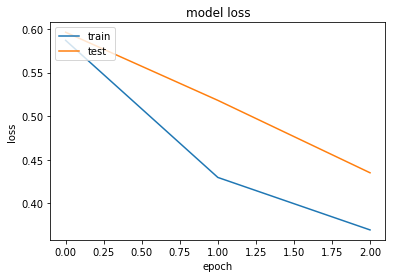

In [331]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0.0,0.06])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This second step definitely helped us to boost the accuracy to around 84%. We could actually try to train the model a bit more given that it still doesn't seem to be overfitting. But our final objective is not to have a perfect classifier, we will be using this as an input for our regressor so we can move on for now and dedicate more resources on this further along if deemed necessary.

## Class Activation Map

Before moving on it is useful to take a look at what is happening under the hood of this model. We can make this model more transparent by visualizing visualizing the regions of an input image that the model considers important for its predictions. A method for doing this is by building a class activation map. In this particular case we will be using a Gradient-weighted Class Activation Mapping ([Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391v1.pdf)). 

This variant is applicable to a much broader range of CNN architectures compared to the traditional CAM method.  uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the important regions in the image. Grad-CAM is a strict generalization of the Class Activation Mapping. Unlike CAM, Grad-CAM requires no re-training and is broadly applicable to any CNN-based architectures. 

In the code below we try to optimize the gradient which maximizes the activation of a particular class:

In [8]:
from keras.models import load_model

m = load_model('models/tuned_clasif_model.h5') # We load the model after returning to a new session

We are optimizing the final `keras.layers.Dense` layer to maximize class output, so we will change to a 'linear' activation as opposed to 'softmax' for better results. The reason for this is because the 'softmax' output can be maximized by minimizing scores for other classes.

In [10]:
from keras import activations

m.layers[-1].activation = activations.linear
m = utils.apply_modifications(m)

In [100]:
from vis.utils import utils
from vis.optimizer import Optimizer
from vis.losses import ActivationMaximization
from scipy.ndimage.interpolation import zoom

def class_activation_map(img_path, model, last_conv_layer_idx, class_idxs, save_name):
    """Generates a gradient based class activation map (CAM) by using positive gradients of `input_tensor`
    with respect to weighted `losses` based on grad-CAM:
    
    Args:
        img_path: Complete path to image.
        model: Trained CNN to classify image
        last_conv_layer: Index to the conv layer whose feature maps should be used to compute gradients
            with respect to filter output.
        class_idxs: List with indexes of the classes that will be mapped
        save_name: Name for the saved image file
        
    Returns:
        Image with class activation heatmap overlay.
    """
    img = img_to_array(load_img(img_path, target_size=(299,299))) #Load image
    img = preprocess_input(np.expand_dims(img, axis=0)) # Process it to the required format
    
    last_conv_layer = model.layers[last_conv_layer_idx]
    
    # We use the Keras-vis optimizer to find the gradients that maximize the activations 
    # of the last conv layer for the specific class
    opt = Optimizer(model.input, losses=[(ActivationMaximization(model.layers[-1], class_idxs),-1)], wrt_tensor=last_conv_layer.output, norm_grads=False)
    _, grads, last_conv_layer_value = opt.minimize(img[0,:,:,:], max_iter=1, grad_modifier=None, verbose=False)
    
    grads = grads / (np.max(grads)+K.epsilon()) # For numerical stability
    
    # Average pooling across all feature maps capturing the importance of each channel to the output
    channel_idx = 1 if K.image_data_format() == 'channels_first' else -1
    other_axis = np.delete(np.arange(len(grads.shape)), channel_idx)
    weights = np.mean(grads, axis=tuple(other_axis))

    
    # Generate heatmap by computing weight * output over feature maps
    output_dims = utils.get_img_shape(last_conv_layer.output)[2:]

    heatmap = np.zeros(shape=output_dims, dtype=K.floatx())

    for i, w in enumerate(weights):
        if channel_idx == -1:
            heatmap += w * last_conv_layer_value[0, ..., i]
        else:
            heatmap += w * last_conv_layer_value[0, i, ...]

    # ReLU thresholding to exclude pattern mismatch information (negative gradients)
    heatmap = np.maximum(heatmap, 0)
    
    # Heatmap is zoomed by zoom_factor because the feature map is smaller than the input image
    input_dims = utils.get_img_shape(model.input)[2:]
    
    zoom_factor = [i / (j * 1.0) for i, j in iter(zip(input_dims, output_dims))]
    heatmap = zoom(heatmap, zoom_factor)
    heatmap = np.uint8(plt.cm.jet(utils.normalize(heatmap))[..., :3] * 255)
    img_init = utils.load_img(img_path, target_size=(299,299))
    plt.imshow(overlay(img_init, heatmap));
    plt.savefig('preview/'+save_name)


We can start by taking a look at the first image we saw above and the generated heatmap:

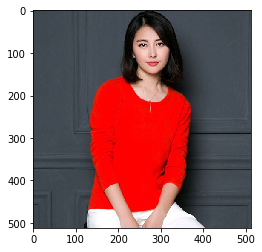

In [98]:
img_path = 'data/valid/blouse/'+os.listdir('data/valid/blouse')[0]
img = plt.imread(img_path)
plt.imshow(img);

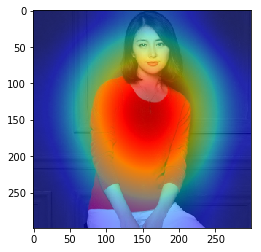

In [101]:
class_activation_map(img_path, m2, 299, [0], 'first.jpg')

By changing the class index in an image with more than one class we can create a heatmap for each class individually. Here we have a full-body image in which we can see a blouse and trousers.

First, we can generate a heatmap to localize the blouse:
![blouse](preview/blouse.jpg)

The heatmap is clearly centered on the blouse. By changing the class index we can also create a heatmap to localize the trousers:
![pants](preview/pants.jpg)

Here are few more examples:

<tr>
    <td> <h1>Blouse&nbsp;</h1> </td>
    <td> <h1>Dress &nbsp;</h1> </td>
    <td> <h1>Skirt &nbsp;</h1> </td>
    <td> <h1>Trousers &nbsp;</h1></td>
</tr>
<tr>
    <td> <img src="preview/blouse2.jpg" alt="Blouse" style="width: 250px;"/> </td>
    <td> <img src="preview/dress1.jpg" alt="Dress" style="width: 250px;"/> </td>
    <td> <img src="preview/skirt.jpg" alt="Skirt" style="width: 250px;"/> </td>
    <td> <img src="preview/trousers1.jpg" alt="Trousers" style="width: 250px;"/> </td>
</tr>

## Keypoints

Phase two of this project is a regressor capable of automatically locating keypoints. We will start by loading the .csv files with the coordinates for each keypoint. In total we will be predicting 20 variables corresponding to the x and y coordinates of: neckline_left, neckline_right, waistli

The coordinates are given in pixels so we will normalize them to values between -1 and 1 for two main reasons. During training we might need to change the size of the images so we want to represent the coordinates in a way that doens't depend on a specific size of the images. Additionally, normalizing is useful to help the model converge faster. We will also be one-hot encoding the categories with the pandas.get_dummies method to convert these categories into numerical values which we can include in our model.

In [7]:
train_df = pd.read_csv('data/keypoints/train.csv')
valid_df = pd.read_csv('data/keypoints/valid.csv')

In [8]:
def process_keypoints_df(df, path, test=False):
    """
    Processes keypoints dataframe
    
    Args:
        df: Dataframe containing image_id, category and keypoint coordinates
        path: path to main images folder
        test: True if input is test set dataframe
    returns:
        Processed keypoint dataset and a separate feature set containing one-hot encoded categories 
    """
    features = pd.get_dummies(df.image_category).values #One-hot encoding categories
    
    # Image_id initially only contains the name of each image
    # In this case, adding the whole path makes it much easier to work with the data
    df = df.copy()
    df.image_id = (df.image_category+'/'+df.image_id).apply(lambda x: path+x) 
    df.drop('image_category', axis=1, inplace=True)
    
    if not test:
        df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: (x-256)/256)
        df.iloc[:,1:] = np.where(df.iloc[:,1:] < -1, -1., df.iloc[:,1:])
    
    return df, features

In [9]:
x_train, train_features = process_keypoints_df(train_df, 'data/train/')
x_valid, valid_features = process_keypoints_df(valid_df, 'data/valid/')
del train_df
del valid_df

In [10]:
# Some keypoints are only applicable to certain clothing categories and appear as missing values for other categories
# We will be filling this values as -1 to avoid problems during training
x_train.fillna(-1, inplace=True) 
x_valid.fillna(-1, inplace=True)

In [11]:
x_valid.head()

image_id  neckline_left_x  \
0  data/valid/blouse/6a6c98e78a8bd9fcff3c424da729...        -0.089844   
1  data/valid/blouse/33fb6510a378f5141e1d2a530673...        -0.257812   
2  data/valid/blouse/68ca3dea36d6cf42edadfaa9255c...        -0.093750   
3  data/valid/blouse/eb3e1fcd967396742a6c3c5eade4...         0.046875   
4  data/valid/blouse/a90e4fd162769f714047f90606f0...        -0.246094   

   neckline_left_y  neckline_right_x  neckline_right_y  waistline_left_x  \
0        -0.464844          0.191406         -0.429688         -0.328125   
1        -0.746094          0.316406         -0.718750         -0.585938   
2        -0.539062          0.101562         -0.476562         -0.289062   
3        -0.613281          0.207031         -0.644531         -0.113281   
4        -0.425781          0.050781         -0.414062         -0.230469   

   waistline_left_y  waistline_right_x  waistline_right_y  cuff_left_out_x  \
0          0.542969           0.324219           0.574219        -0.195312   
1          0.433594           0.503906           0.496094        -0.757812   
2          0.691406           0.312500           0.582031        -0.500000   
3          0.242188           0.410156           0.191406        -0.250000   
4          0.726562           0.363281           0.671875        -0.511719   

          ...          cuff_right_out_x  cuff_right_out_y  hemline_left_x  \
0         ...                 -0.195312          0.253906            -1.0   
1         ...                  0.734375          0.917969            -1.0   
2         ...                  0.265625          0.226562            -1.0   
3         ...                  0.335938          0.238281            -1.0   
4         ...                  0.246094         -0.203125            -1.0   

   hemline_left_y  hemline_right_x  hemline_right_y  bottom_left_out_x  \
0            -1.0             -1.0             -1.0               -1.0   
1            -1.0             -1.0             -1.0               -1.0   
2            -1.0             -1.0             -1.0               -1.0   
3            -1.0             -1.0             -1.0               -1.0   
4            -1.0             -1.0             -1.0               -1.0   

   bottom_left_out_y  bottom_right_out_x  bottom_right_out_y  
0               -1.0                -1.0                -1.0  
1               -1.0                -1.0                -1.0  
2               -1.0                -1.0                -1.0  
3               -1.0                -1.0                -1.0  
4               -1.0                -1.0                -1.0  

[5 rows x 21 columns]

As we can see above, we have a total of 20 variables which our regressor would have to predict and a column which contains the complete path of each image. This way we don't have to load the images directly into memory as numpy arrays. Instead, we yield batches of images when needed during training.

Now it's time to take a look at the images with the keypoints:

In [12]:
def plot_data(img_path, keypoints, axis, sz):
    """
    Plots image with keypoints
    
    Args:
        img_path: Complete path to image.
        keypoints: numpy array with normalized keypoint coordinates
        axis: Matplotlib axes for plotting
        sz: image size to transform coordinates into right size
    """
        
    img = plt.imread(img_path)
    axis.imshow(np.squeeze(img))
    keypoints = keypoints * sz/2 + sz/2
    axis.scatter(keypoints[0::2], 
        keypoints[1::2], 
        marker='o', 
        c='c', 
        s=40)

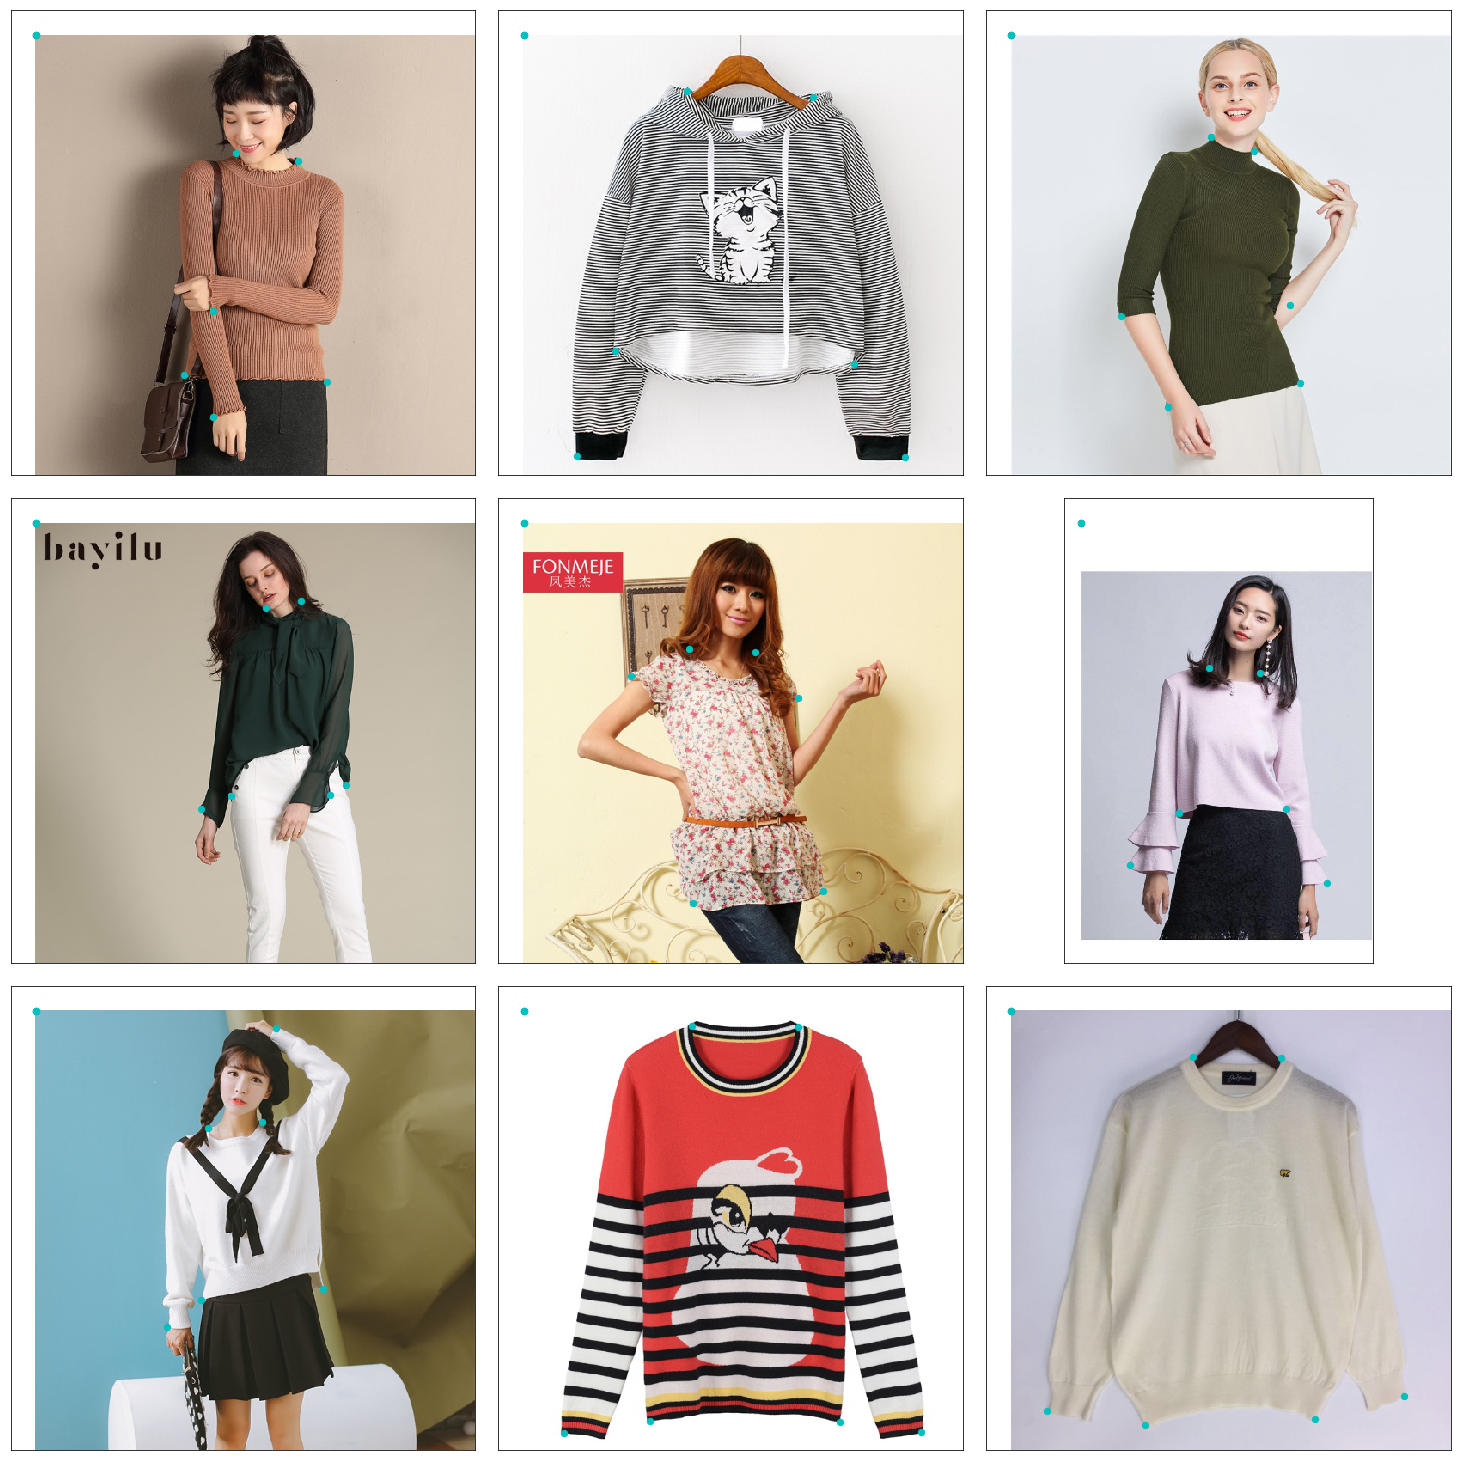

In [13]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(x_valid.image_id[i], x_valid.iloc[:,1:].values[i], ax, 512)

These images are taken from the blouses subset. The idea here is to check that the keypoints are correctly located and to have a visual idea of what we want to accomplish.

For our classification problem we used Keras built-in Image Data Generator to yield images during training and for data augmentation. Keras currently does not support this for regression tasks. Additionally, every transformation applied to the images for data augmentation has to be correctly mirrored with the keypoints or else we will just end up confusing the model.

So next we will be building our custom generator:

In [46]:
from skimage.transform import resize
from skimage.transform import rotate

def pad_array(img_array, target_sz, sz=(512, 512)):
    """
    Pads images which do not conform to the desired size
    
    Args:
        img_array: Image as numpy array
        target_size: Desired size of the images
        sz: Standard image size (e.g. Standard size is 512x512 but can vary with sizes like 512x476, 477x477, ext.)
    Returns:
        Padded (and/or resized) image as numpy array
    """
    h, w, _ = img_array.shape
    if h < sz[0]:
        img_array = np.concatenate((img_array, np.ones(shape=(sz[0]-h,w,1))), axis=0)
        h = sz[0]
    if w < sz[1]:
        img_array = np.concatenate((img_array, np.ones(shape=(h, sz[1]-w,1))), axis=1)
        
    if target_sz != sz:
        img_array = resize(img_array, target_sz)
    return img_array


def generator_from_df(df, batch_size, target_size, flip_ratio=0.2, rot_ratio=0.2, std_img_size=(512,512), features=None):
    """
    Generator that yields (X, Y) or ([X, X2], Y) if additional features are added.
    Assumes input DataFrame df has 'image_id' column which is a full path to the image file.
    Args:
        df: Dataframe containing training or validation data
        batch_size: Size of batches for training
        target_size: Desired size of the images
        flip_ratio: Ratio of pictures in each batch that will be flipped
        rot_ratio: Ratio of pictures in each batch that will be rotated
        sz: Standard image size (e.g. Standard size is 512x512 but can vary with sizes like 512x476, 477x477, ext.)
        features: Additional inputs that can be used during training
    Yields:
        Batches of X and Y data to be used for training
    """
    if features is not None:
        assert features.shape[0] == df.shape[0], "Feature and df rows must match"

    nbatches, n_skipped_per_epoch = divmod(df.shape[0], batch_size)

    count = 1
    epoch = 0
    
    flip_indices= [(0, 2), (1, 3), (4, 6), (5, 7), (8, 10),
                   (9, 11), (12, 14), (13, 15), (16, 18), (17, 19)]

    # New epoch.
    while 1:

        # The advantage of the DataFrame holding the image file name
        # and the labels is that the entire df fits into memory and
        # can be easily shuffled at the start of each epoch.
        #
        # Shuffle each epoch using the tricky pandas .sample() way.
        df = df.sample(frac=1)  # frac=1 is same as shuffling df.
        
        epoch += 1
        i, j = 0, batch_size

        # Mini-batches within epoch.
        mini_batches_completed = 0
        for _ in range(nbatches):

            sub = df.iloc[i:j]

            try:
                X = np.array([(pad_array(img_to_array(load_img(f, grayscale=True))/255.0, sz=std_img_size,target_sz=target_size)) for f in sub.image_id])
                Y = sub.iloc[:,1:].values
                
                # Data augmentation by flipping half of the images in each batch
                flip_idxs = np.random.choice(batch_size,round(batch_size*flip_ratio),replace=False)
                X[flip_idxs] = X[flip_idxs, :,::-1,:]
                Y[flip_idxs, ::2] = np.multiply(Y[flip_idxs, ::2], np.where(Y[flip_idxs, ::2] != -1., -1, 1))
                
                for a,b in flip_indices:
                    Y[flip_idxs, a], Y[flip_idxs, b] = (Y[flip_idxs, b], Y[flip_idxs, a])
                    
                rot_idxs = np.random.choice(batch_size,round(batch_size*rot_ratio),replace=False)
                
                angle = np.random.randint(-30, 30)
                for i in rot_idxs:
                    X[i] = rotate(X[i, :, :], angle)
                angle = np.radians(angle)
                R = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
                Y = Y.reshape(len(Y), 10, 2)
                Y[rot_idxs] = np.dot(Y[rot_idxs], R)
                Y = Y.reshape(len(Y), 20)
                Y = np.clip(Y, -1, 1)                

                if features is None:
                    # Simple model, one input, one output.
                    mini_batches_completed += 1
                    
                    yield X, Y

                else:
                    # For merged model: two input, one output.
                    X2 = features[sub.index.values]
                    mini_batches_completed += 1

                    yield [X, X2], Y

            except IOError as err:

                count -= 1
                
            i = j
            j += batch_size
            count += 1

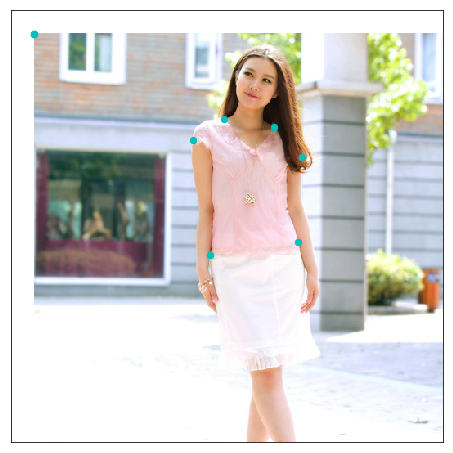

In [15]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
plot_data(x_train.image_id[1], x_train.iloc[:,1:].values[1], ax, 512)

Let's check that our generator is working correctly. Above we can see an image in it's current format. Below we will yield a small batch of images to check that the outpus is as desired, taking into account flipping, rotating and possible resizing:

In [16]:
a = generator_from_df(x_train[:4], batch_size=2, target_size=(64,64), flip_ratio=0.5, rot_ratio=1., features=train_features[:4])

In [17]:
b, c = next(a)

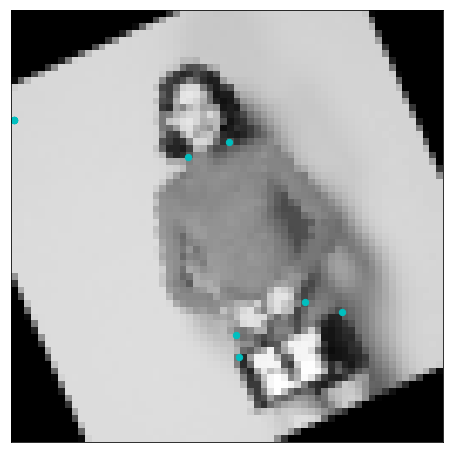

In [18]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(np.squeeze(b[0][1]), cmap='gray')
keypoints = c[1] * 32 + 32
ax.scatter(keypoints[0::2], keypoints[1::2], marker='o', c='c', s=40)

## Keras regressor with custom generator and data augmentation

It is now time to build our keypoint regressor with Keras:

In [19]:
batch_size = 128
sz = 256

In [20]:
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Input, Flatten, Dense, Concatenate

main_input = Input(shape=(sz, sz, 1))
x = Convolution2D(32, 3, activation='relu')(main_input)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x = Convolution2D(64, 3, activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x = Convolution2D(128, 3, activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)
 
flat = Flatten()(x)
aux_input = Input(shape=(5,))
x = Concatenate(axis=1)([flat, aux_input])

x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)

predictions = Dense(20)(x)

kp_model = Model(inputs=[main_input, aux_input], outputs=predictions)


# Summarize the model
kp_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 254, 254, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 127, 127, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 127, 127, 32) 0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

The model starts with three convolutional layers with increasing depth. Each one followed by a max pooling and a dropout layer. This helps to reduce overfitting and the computational cost of the model. After this the output of the third convolutional layer is flattened and concatenated with the additional information about the class of the image. Preliminary experiments showed better results including this information which would be predicted by our classification model. Finally additional dense layers and dropout are added, finishing with a dense layers which gives us the prediction for each of our 20 keypoint coordinates.

In [22]:
kp_model.compile(loss='mean_squared_error', optimizer='rmsprop')

kp_train_generator = generator_from_df(x_train, batch_size=batch_size, target_size=(sz,sz), flip_ratio=0.25, rot_ratio=0.35, features=train_features)
kp_valid_generator = generator_from_df(x_valid, batch_size=batch_size, target_size=(sz,sz), features=valid_features)

nbatches_train, mod = divmod(x_train.shape[0], batch_size)
nbatches_valid, mod = divmod(x_valid.shape[0], batch_size)

nworkers=4

hist3 = kp_model.fit_generator(
    kp_train_generator,
    steps_per_epoch=nbatches_train,
    epochs=8,
    verbose=1,
    validation_data=kp_valid_generator,
    validation_steps=nbatches_valid,
    workers=nworkers)
kp_model.save('kp_model.h5')

Epoch 1/8
266/266 [==============================] - 583s 2s/step - loss: 7.9798 - val_loss: 0.0646
Epoch 2/8
266/266 [==============================] - 466s 2s/step - loss: 0.0605 - val_loss: 0.0510
Epoch 3/8
266/266 [==============================] - 467s 2s/step - loss: 0.0506 - val_loss: 0.0421
Epoch 4/8
266/266 [==============================] - 467s 2s/step - loss: 0.0461 - val_loss: 0.0409
Epoch 5/8
266/266 [==============================] - 468s 2s/step - loss: 0.0433 - val_loss: 0.0403
Epoch 6/8
266/266 [==============================] - 469s 2s/step - loss: 0.0412 - val_loss: 0.0386
Epoch 7/8
266/266 [==============================] - 467s 2s/step - loss: 0.0398 - val_loss: 0.0375
Epoch 8/8
266/266 [==============================] - 475s 2s/step - loss: 0.0383 - val_loss: 0.0379


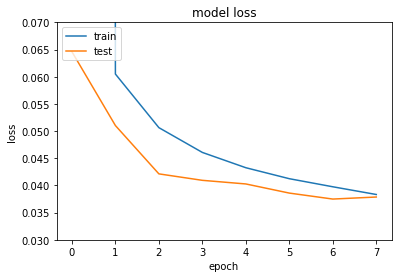

In [25]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0.03,0.07])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

After 8 epochs training seems to have flattened out. We can now test our model to evaluate the results. 

In [135]:
model2 = load_model('models/keypoint_regressor3.h5') # Loading the model when starting a new session

In [88]:
import random
idxs=[random.randrange(1,len(x_valid),1) for _ in range(9)] # We choose a set of random indexes to check the model

In [89]:
# Loading the images and features into the right format 
X = np.array([(pad_array(img_to_array(load_img(f, grayscale=True))/255.0,target_sz=(256,256))) for f in x_valid.image_id.iloc[idxs]])
test_features = valid_features[idxs]

A post-processing step which can help to clean up the result is using the knowledge that some keypoints are not applicable to certain clothing categories. So we can create a dictionary with the indexes of the columns that are not applicable to each category and force these columns to -1:

In [91]:
blouse_cols = list(range(12,20))
dress_cols = list(range(16,20))
outwear_cols = list(range(4,8)) + list(range(16,20))
skirt_cols = list(range(0,4)) + list(range(8,12)) + list(range(16,20))
trousers_cols = list(range(0,4)) + list(range(8,16))

cols_dict = {i:c for i,c in zip(range(0,5),[blouse_cols,dress_cols,outwear_cols,skirt_cols, trousers_cols])}

res = kp_model.predict([X, test_features]) #Using model to predict the keypoints of the images
for i in range(len(res)):
    res[i][cols_dict[np.argmax(test_features[i])]] = -1

Having our images and the predictions we can print them and check the result visually:

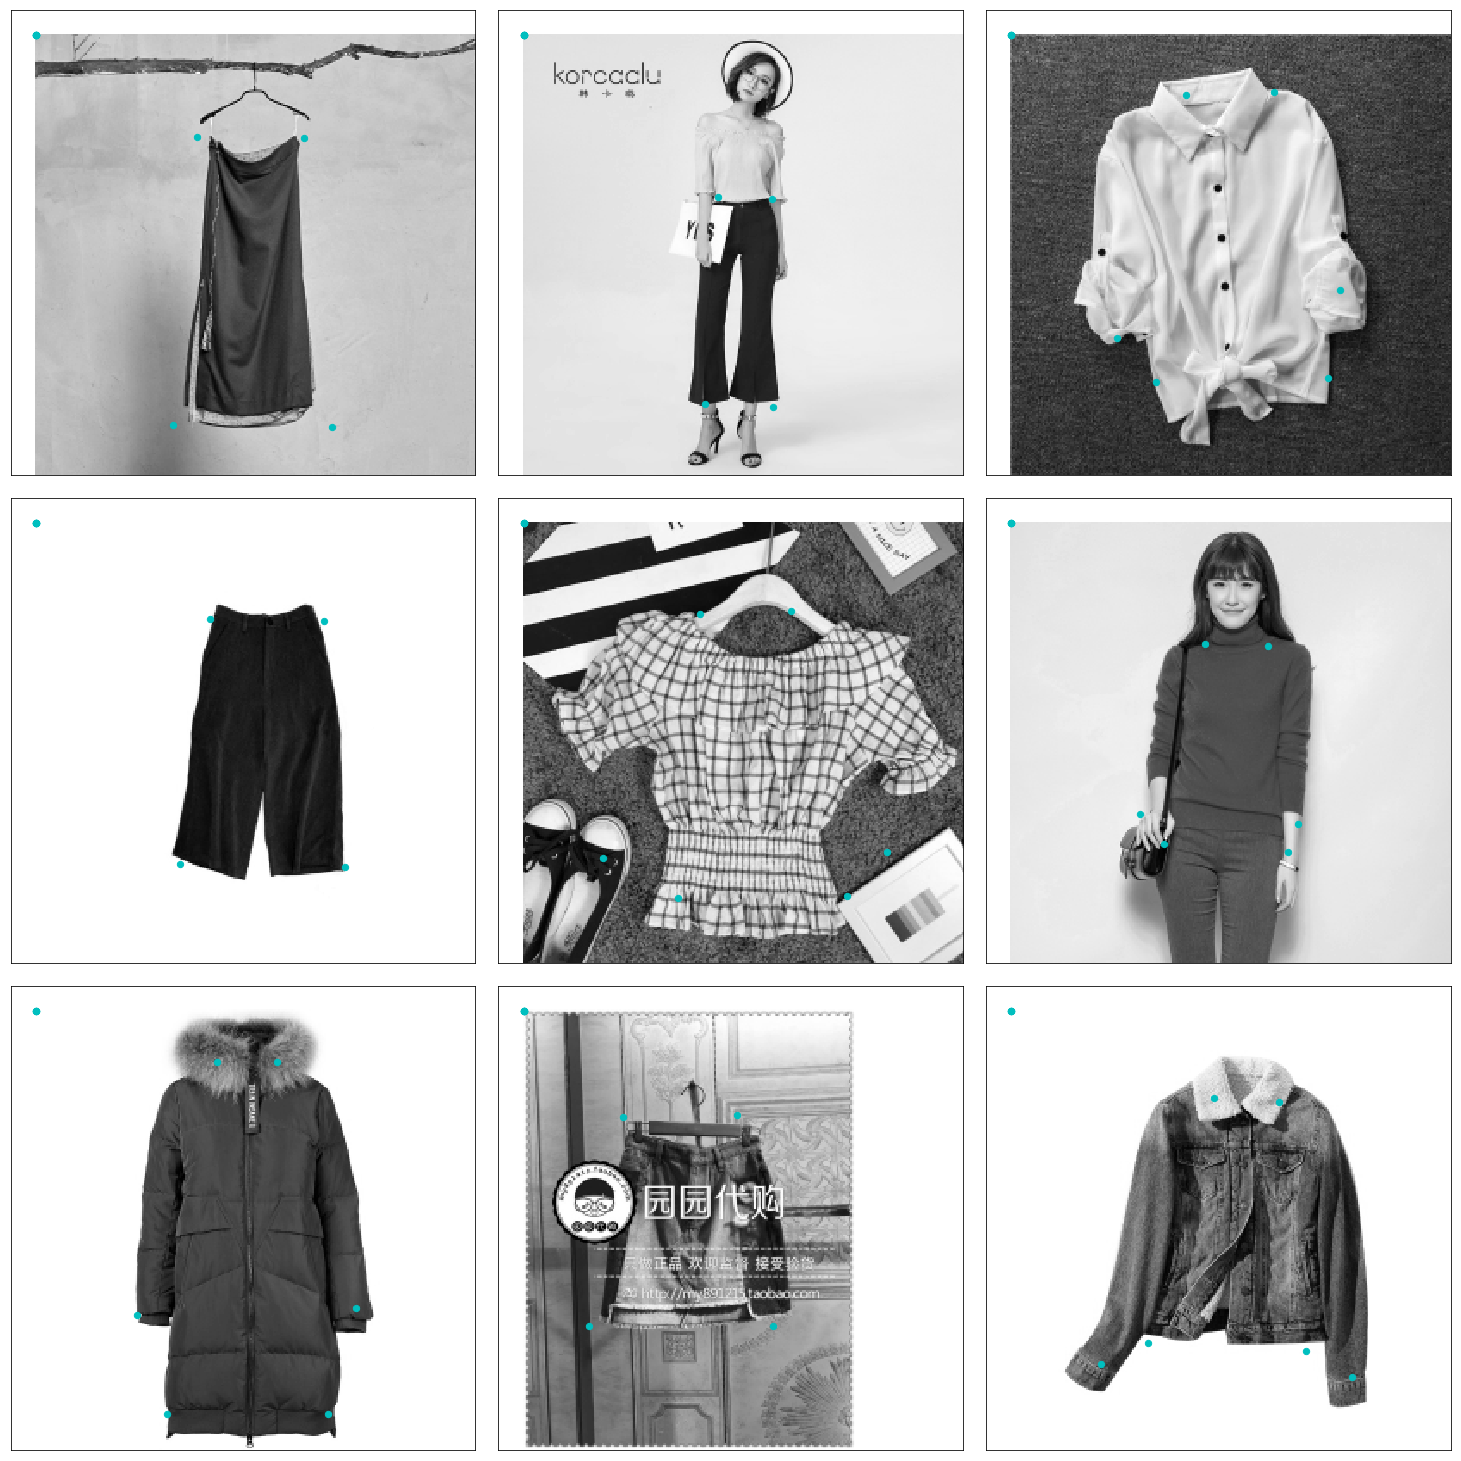

In [92]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X[i]), cmap='gray')
    keypoints = res[i] * 128 + 128
    ax.scatter(keypoints[0::2], keypoints[1::2], marker='o', c='c', s=40)

In the images above, the keypoints seem to be pretty close to where they are supposed to be, even on the slightly wrinkled shirt on top and the sleeve that points out in the last picture. The picture in the middle has a blouse with a less common design and many other objects in the image leading to the worst located keypoints out of the nine. Still, in this case we used images from the validation set, that means that the model already used them for validation during training so our next step would be to create our pipeline and check it on the test set.

## Pipeline and testing

First we will load and preprocess the .csv file containing the data about the test set. After that we will condense the whole process into a single function that takes the paths of images as its input and returns the keypoint predictions.

In [97]:
test_df = pd.read_csv('data/keypoints/test.csv')
test_df, _ = process_keypoints_df(test_df, 'data/test/', test=True)

In [98]:
# Load models if needed
cl_model = load_model('models/tuned_clasif_model.h5')
kp_model = load_model('models/kp_model.h5')

In [103]:
def keypoint_regressor(images, cl_model, kp_model):
    """
    Predicts keypoints of clothing images
    
    Args:
        images: paths to images
        cl_model: Trained classification model for clothing category prediction
        kp_model: Trained regression model for keypoint prediction
    Returns:
        Images and keypoint coordinate predictions as numpy arrays
    """
    X = np.array([(preprocess_input(img_to_array(load_img(img, target_size=(299,299))))) for img in images])
    class_predictions = cl_model.predict(X)
    
    X = np.array([(pad_array(img_to_array(load_img(img, grayscale=True))/255.0,target_sz=(256,256))) for img in images])
    kp_regressions = kp_model.predict([X, class_predictions])
    
    for i in range(len(kp_regressions)):
        kp_regressions[i][cols_dict[np.argmax(class_predictions[i])]] = -1
    
    return X, kp_regressions

In [108]:
idxs=[random.randrange(1,len(test_df),1) for _ in range(9)] # We choose a set of random indexes to check the model

In [109]:
X, keypoints = keypoint_regressor(test_df.image_id[idxs], cl_model, kp_model)

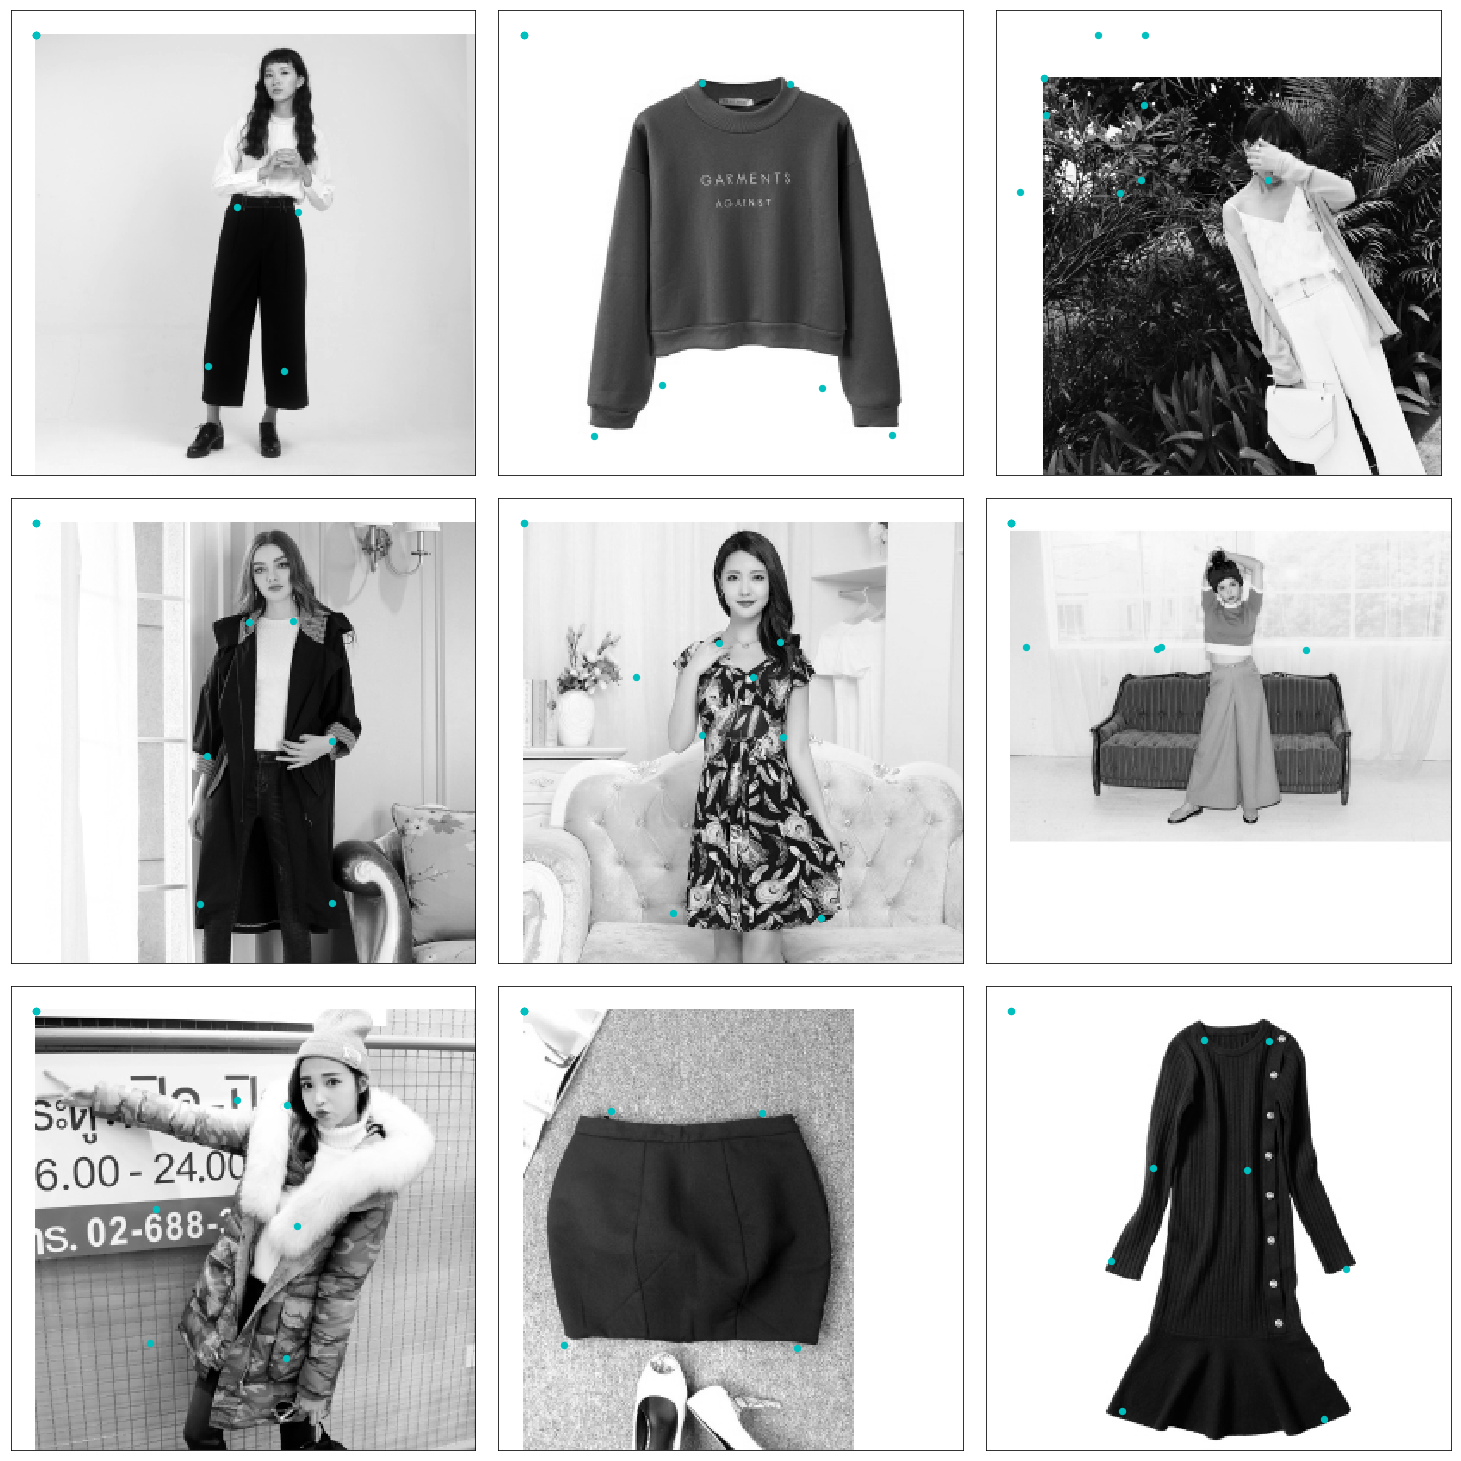

In [110]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X[i]), cmap='gray')
    kp = keypoints[i] * 128 + 128
    ax.scatter(kp[0::2], kp[1::2], marker='o', c='c', s=40)

Comparing this results to the ones above, it seems like the model performs much better on studio pictures compared to images taken in the wild with stranger poses. For example, the keypoints in the first image of the third row correctly follows the direction the girl is leaning towards but not good enough. It still seems to prefer the more standard location and direction of the clothes.

The model also seems to peform relatively well on skirts and pants which are a bit simpler than upper-body clothing. Still, it was able to accuratly find the neckline and sleevs of the last picture and the first picture of the middle column.

The worst performers are the first two images of the last column. These are obviously less standard with real-world backgrounds, less common postures and different angles. This shows us where we can focus to improve the model.

## Conclusion and future steps

Throughout this notebook we explored some of the challenges we can encounter while tackling the FashionAI keypoint location challenge. 

We explored generators for training with large datasets, a custom generator that can be used for regression tasks in Keras with data augmentation with keypoints, we generated class activation maps to better understand our convolutional neural network, and we finished by setting the different pieces together to create a single function that takes images of different types of clothing and returns the predicted keypoints.

There are several steps we can take to improve our model. For example, as mentioned earlier, we could try to improve our class prediction. But looking at the results, a more worthwile approach coul be focusing on less "neat" cases which would help us to improve the precision of the model for pictures taken in the wild. For this we could use the DeepFashion database to augment our current database, a large-scale clothes database with over 800,000 diverse fashion images ranging from well-posed shop images to unconstrained consumer photos. The main benefit is that this dataset has very rich annotations ranging from labels and attributes to bounding boxes and clothing landmarks.

We can also improve the pipeline in different ways. For some, specialist models created for very specific keypoints have helped to improve the performance of facial keypoint recognition models. This approach can also be applied here by creating separate models that focus on different keypoints and using the output of all of these specialist models.

Another similar approach is cascading models. Ziwei Liu et al. show in their paper [Fashion Landmark Detection in the Wild](https://arxiv.org/abs/1608.03049) an approach to fashion alignment by cascading multiple convolutional neural networks in three stages. The first model predicts rough landmark positions and pseudo-labels representing configurations like categories and poses. SOmewhat similar to what we have done so far in this notebook. This is used as an input to the second model tries to estimate the offsets that should be made to "correct" the predictions of the first model. The third model uses the output of the second model as its input with the image and also estimates landmark offsets with contextual pseudo-labels. 